Ref of MaskRCNN results: https://github.com/michhar/pytorch-mask-rcnn-samples/blob/master/visualize.py 

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio
import cv2
from IPython import display
import colorsys
import random

In [2]:
# object detection is a brand new feature only available in latest version 1.1.0 not before that...
print(torch.__version__)

1.11.0+cu113


In [3]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device   = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
device

Tesla T4


device(type='cuda')

In [5]:
# for Colab user
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Saving Screen Recording 2022-05-11 at 10.05.42 AM.mov to Screen Recording 2022-05-11 at 10.05.42 AM.mov
Screen Recording 2022-05-11 at 10.05.42 AM.mov


In [6]:
# for Anaconda user
# fname = "協助翻身坐立.mp4" 

In [7]:
# get video file informaiton
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
__width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
__height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('No. of frames = ', total_frames, ", w =", __width, ", h =", __height, ", fps=", fps)

No. of frames =  181 , w = 1254 , h = 664 , fps= 60.0


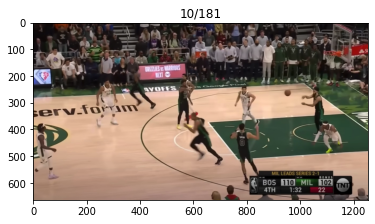

In [8]:
# take a look at the input video
MaxFrame = 10
frame_count = 1
try:
    while(frame_count <= MaxFrame):
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = vid.get_data(frame_count)  # Capture frame-by-frame
        frame_count += 1
        plt.imshow(frame)
        plt.pause(0.1)
except:
    print("Read video error!")

Load mask RCNN

In [9]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform

In [11]:
RecognitionThreshold = 0.7   # 只取 score > RecognitionThreshold 的 subject

In [12]:
rect_th=3
text_th=10
text_size=2

In [13]:
First_tracking_frame = 1  
End_tracking_frame = 150

In [14]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

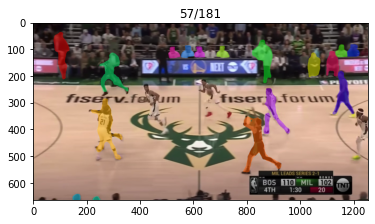

In [ ]:
# 送 MaskRCNN 畫 people 的 bbox
fname1 = fname + '_processed_video.mp4'
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
print('No. of frames = ', total_frames)
frame_count = 1
alpha=0.5

# ----- FRAME LIMIT CHANGED TO TOTAL FRAME ----- 
End_tracking_frame = total_frames
# ----- FRAME LIMIT CHANGED TO TOTAL FRAME ----- 


# ---------- ADDED FOR VIDEO WRITE ----------
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
writer = imageio.get_writer(fname1, fps=fps)
# ---------- ADDED FOR VIDEO WRITE ----------

while(cap.isOpened()):  
    if(frame_count > End_tracking_frame):
        break
    success, frame = cap.read()  # Capture frame-by-frame

    if success == True:
        # 先把 frame 轉到 First_tracking_frame, show 出此 frame 上 subject index
        if(frame_count < First_tracking_frame):
            frame_count += 1
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
            img = transform(frame).to(device) # Apply the transform to the image
            pred = model([img]) # Pass the image to the model
            pred_score = pred[0]['scores'].cpu().detach().numpy()
            pred_labels = pred[0]['labels'].cpu().numpy() # Get the Prediction Score
            pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
            pred_masks = list(pred[0]['masks'].cpu().detach().numpy())

            person_lst = []  #format = [id, box]
            person_id = 1
            i = 0
            for i in range(pred_score.shape[0]):
                if(pred_score[i] < RecognitionThreshold): # ignore objects with small score
                    break
                elif (pred_labels[i] ==1): # if object = person
                    person_lst.append([person_id, pred_boxes[i], pred_masks[i]])
                    person_id += 1
                
            display.clear_output(wait=True)
            plt.title(str(frame_count)+'/'+str(total_frames))
            colors = random_colors(len(person_lst)) # Generate random colors
            for i in range(len(person_lst)):
                pid = person_lst[i][0]
                box = person_lst[i][1]
                mask = person_lst[i][2]
                
                #cv2.rectangle(frame, box[0], box[1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
                #cv2.putText(frame,str(pid), box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
               
                color = colors[i]
                for c in range(3):
                    frame[:, :, c] = np.where(mask > 0.5,
                                              frame[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                              frame[:, :, c])
            plt.imshow(frame)
            plt.show()
            plt.pause(0.1)
            frame_count = frame_count + 1

            # ---------- ADDED FOR VIDEO WRITE ----------
            writer.append_data(frame)
            # ---------- ADDED FOR VIDEO WRITE ----------

    # ----- ADDED FOR FALSE VIDEO CAPTURE ----- 
    else:
        break
    # ----- ADDED FOR FASLE VIDEO CAPTURE ----- 

# ---------- ADDED FOR VIDEO WRITE ----------
writer.close()
# ---------- ADDED FOR VIDEO WRITE ----------